# XGBoost training/predict/evaluate

Train the model to predict the recovery M3.

---
# Setup

## Ingestion

In [1]:
%run ingestion.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   facility      810 non-null    object 
 1   date          481 non-null    object 
 2   timeStart     810 non-null    object 
 3   timeEnd       481 non-null    object 
 4   supplierCode  481 non-null    object 
 5   suppliedM3    810 non-null    float64
 6   recoveredM3   810 non-null    float64
 7   processTime   329 non-null    object 
 8   supplier      329 non-null    object 
dtypes: float64(2), object(7)
memory usage: 57.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   facility_code     810 non-null    int64         
 1   supplier_code     810 non-null    int64         
 2   process_date      810 non-null    int64     

## PYTHONPATH

In [2]:
if f"{os.getcwd()}/../../../lib" not in sys.path:
    sys.path.append(f"{os.getcwd()}/../../../lib") 

## Logging

In [3]:
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
logger = logging.getLogger("training")

## Dependencies

In [4]:
import xgboost as xgb
print(xgb.__version__)

from sklearn.metrics import (
    mean_squared_error
)
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    GridSearchCV
)
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

1.7.3


In [5]:
%load_ext autoreload
%autoreload 2
from util_pandas.ml import (
    stratified_shuffle_split_into_train_test
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constant

In [6]:
DEBUG = False

---
# Data

In [7]:
df

,facility_code,supplier_code,process_date,start_date_time,start_hour,start_time_sin_x,start_time_cos_y,dayofweek,dayofweek_sin_x,dayofweek_cos_y,is_holiday,process_time,input,output,throughput,recovery_rate
0,0,4,1,2022-08-01 08:29:00,8,0.796002,-0.605294,0,0.000000,1.000000,0,2280.0,2.00,1.55,0.040789,0.775000
1,0,5,1,2022-08-01 09:27:00,9,0.619094,-0.785317,0,0.000000,1.000000,0,7260.0,6.80,4.15,0.034298,0.610294
2,0,4,1,2022-08-01 11:38:00,11,0.095846,-0.995396,0,0.000000,1.000000,0,2580.0,1.95,1.55,0.036047,0.794872
3,0,6,1,2022-08-01 12:40:00,12,-0.173648,-0.984808,0,0.000000,1.000000,0,5040.0,3.95,2.55,0.030357,0.645570
4,0,5,1,2022-08-01 14:25:00,14,-0.591309,-0.806445,0,0.000000,1.000000,0,7440.0,5.30,3.10,0.025000,0.584906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,0,6,30,2022-09-30 11:40:00,11,0.087156,-0.996195,4,-0.433884,-0.900969,0,3660.0,3.70,2.35,0.038525,0.635135
806,0,5,30,2022-09-30 12:52:00,12,-0.224951,-0.974370,4,-0.433884,-0.900969,0,6240.0,6.35,4.55,0.043750,0.716535
807,1,0,30,2022-09-30 13:48:00,13,-0.453991,-0.891007,4,-0.433884,-0.900969,0,220.0,4.53,2.73,0.744545,0.602649
808,0,4,30,2022-09-30 15:02:00,15,-0.713251,-0.700909,4,-0.433884,-0.900969,0,2400.0,2.00,1.45,0.036250,0.725000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   facility_code     810 non-null    int64         
 1   supplier_code     810 non-null    int64         
 2   process_date      810 non-null    int64         
 3   start_date_time   810 non-null    datetime64[ns]
 4   start_hour        810 non-null    int64         
 5   start_time_sin_x  810 non-null    float32       
 6   start_time_cos_y  810 non-null    float32       
 7   dayofweek         810 non-null    int64         
 8   dayofweek_sin_x   810 non-null    float64       
 9   dayofweek_cos_y   810 non-null    float64       
 10  is_holiday        810 non-null    uint8         
 11  process_time      810 non-null    float32       
 12  input             810 non-null    float32       
 13  output            810 non-null    float32       
 14  throughput        810 non-

## Drop 

Drop non feature columns e.g. throughput.

In [9]:
df.drop([
    COLUMN_START_TIME,
    COLUMN_RECOVERY_RATE,
    COLUMN_THROUGHPUT,
    COLUMN_PROCESS_TIME,
], axis=1, inplace=True)
df

,facility_code,supplier_code,process_date,start_hour,start_time_sin_x,start_time_cos_y,dayofweek,dayofweek_sin_x,dayofweek_cos_y,is_holiday,input,output
0,0,4,1,8,0.796002,-0.605294,0,0.000000,1.000000,0,2.00,1.55
1,0,5,1,9,0.619094,-0.785317,0,0.000000,1.000000,0,6.80,4.15
2,0,4,1,11,0.095846,-0.995396,0,0.000000,1.000000,0,1.95,1.55
3,0,6,1,12,-0.173648,-0.984808,0,0.000000,1.000000,0,3.95,2.55
4,0,5,1,14,-0.591309,-0.806445,0,0.000000,1.000000,0,5.30,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...
805,0,6,30,11,0.087156,-0.996195,4,-0.433884,-0.900969,0,3.70,2.35
806,0,5,30,12,-0.224951,-0.974370,4,-0.433884,-0.900969,0,6.35,4.55
807,1,0,30,13,-0.453991,-0.891007,4,-0.433884,-0.900969,0,4.53,2.73
808,0,4,30,15,-0.713251,-0.700909,4,-0.433884,-0.900969,0,2.00,1.45


## Train/Test Split

Split data into train and test with preserving the strata of supplier code. By preserving the propotion of supplier code, the propotion of facilities in the data is preserved as well.

In [10]:
train_data_set: pd.DataFrame
test_data_set: pd.DataFrame
    
train_data_set, test_data_set = stratified_shuffle_split_into_train_test(
    dataframe=df, column_name=COLUMN_SUPPLIER_CODE
)

In [11]:
train_data_set[COLUMN_SUPPLIER_CODE].value_counts() / len(train_data_set)

6    0.200617
5    0.200617
4    0.191358
0    0.114198
3    0.104938
2    0.095679
1    0.092593
Name: supplier_code, dtype: float64

In [12]:
test_data_set[COLUMN_SUPPLIER_CODE].value_counts() / len(test_data_set)

5    0.203704
6    0.203704
4    0.191358
0    0.111111
3    0.104938
1    0.092593
2    0.092593
Name: supplier_code, dtype: float64

In [13]:
X_train = train_data_set.drop(COLUMN_OUTPUT, axis=1)
y_train = train_data_set[COLUMN_OUTPUT].copy()
del train_data_set

In [14]:
if DEBUG:
    display(X_train)
    display(y_train)

In [15]:
X_test = test_data_set.drop(COLUMN_OUTPUT, axis=1)
y_test = test_data_set[COLUMN_OUTPUT].copy()
del test_data_set

---
# Model Training

## XGBoost
* [XGBoost Python API Reference](https://xgboost.readthedocs.io/en/stable/python/python_api.html)
* [XGBoost parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)
* [Learning Task Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)

## Grid Search/K Hold Cross Validation

* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [16]:
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 7, 8],
    "n_estimators": [25, 50, 75, 100, 125, 150, 200],
    "learning_rate": [0.07, 0.09, 0.11, 0.13, 0.15, 0.2, 0.3]
}

In [17]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric=mean_squared_error,
)

In [18]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
search = GridSearchCV(
    model, 
    param_grid, 
    cv=cv, 
    n_jobs=-1,
    verbose=1, 
    return_train_score=True,
).fit(X_train, y_train)

Fitting 25 folds for each of 343 candidates, totalling 8575 fits


In [19]:
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 100}


In [20]:
estimator = search.best_estimator_

In [21]:
print("Best Estimator: \n{}\n".format(search.best_estimator_))
print("Best Parameters: \n{}\n".format(search.best_params_))
print("Best Test Score: \n{}\n".format(search.best_score_))

Best Estimator: 
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x15fd22d30>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

Best Parameters: 
{'learning_rate': 0.07, 'max_depth': 2, 'n_estimators': 100}

Best Test Score: 
0.9144626740717338



## Feature Importance

Importance of the columns contributing.

* [get_score(fmap='', importance_type='weight') method](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score) in [Booster](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster) 

> Get feature importance of each feature. For tree model Importance type can be defined as:
> * ‘weight’: the number of times a feature is used to split the data across all trees.
> * ‘gain’: the average gain across all splits the feature is used in.
> * ‘cover’: the average coverage across all splits the feature is used in.
> * ‘total_gain’: the total gain across all splits the feature is used in.
> * ‘total_cover’: the total coverage across all splits the feature is used in.

In [22]:
estimator.get_booster().get_score(importance_type="gain")

{'facility_code': 0.4798576235771179,
 'supplier_code': 0.20751312375068665,
 'process_date': 0.19920885562896729,
 'start_hour': 0.9179773330688477,
 'start_time_sin_x': 2.315373420715332,
 'start_time_cos_y': 0.19310562312602997,
 'dayofweek': 1.0352158546447754,
 'dayofweek_sin_x': 0.9497948884963989,
 'dayofweek_cos_y': 0.16932298243045807,
 'input': 25.80611228942871}

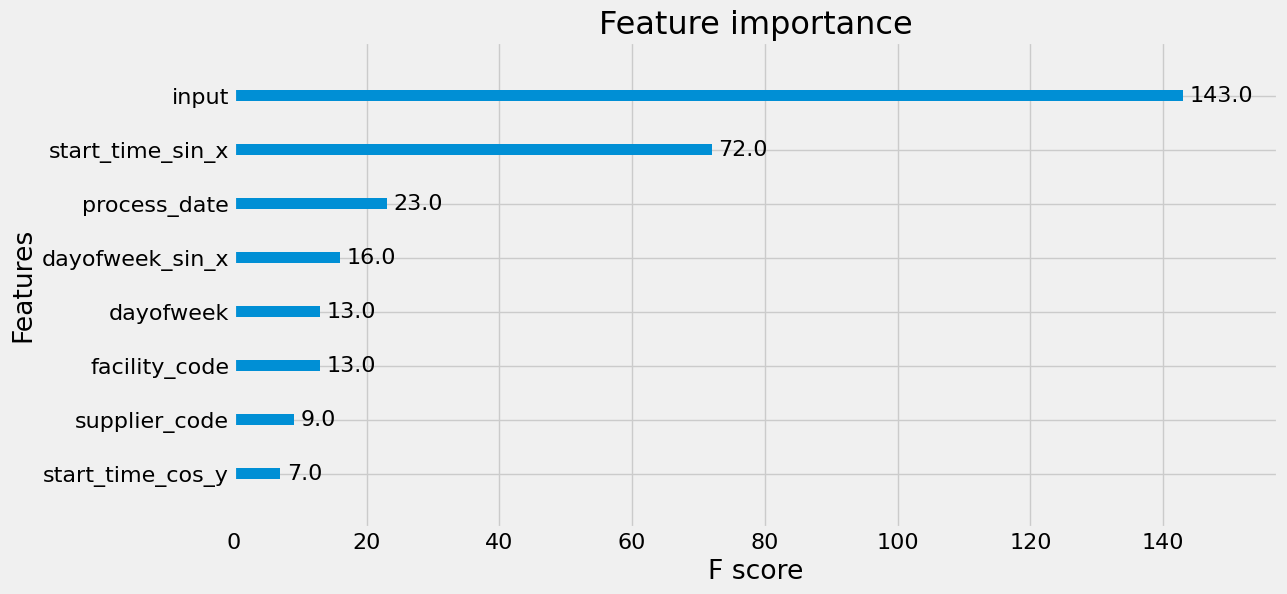

In [23]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(estimator, max_num_features=8, ax=ax)
plt.show();

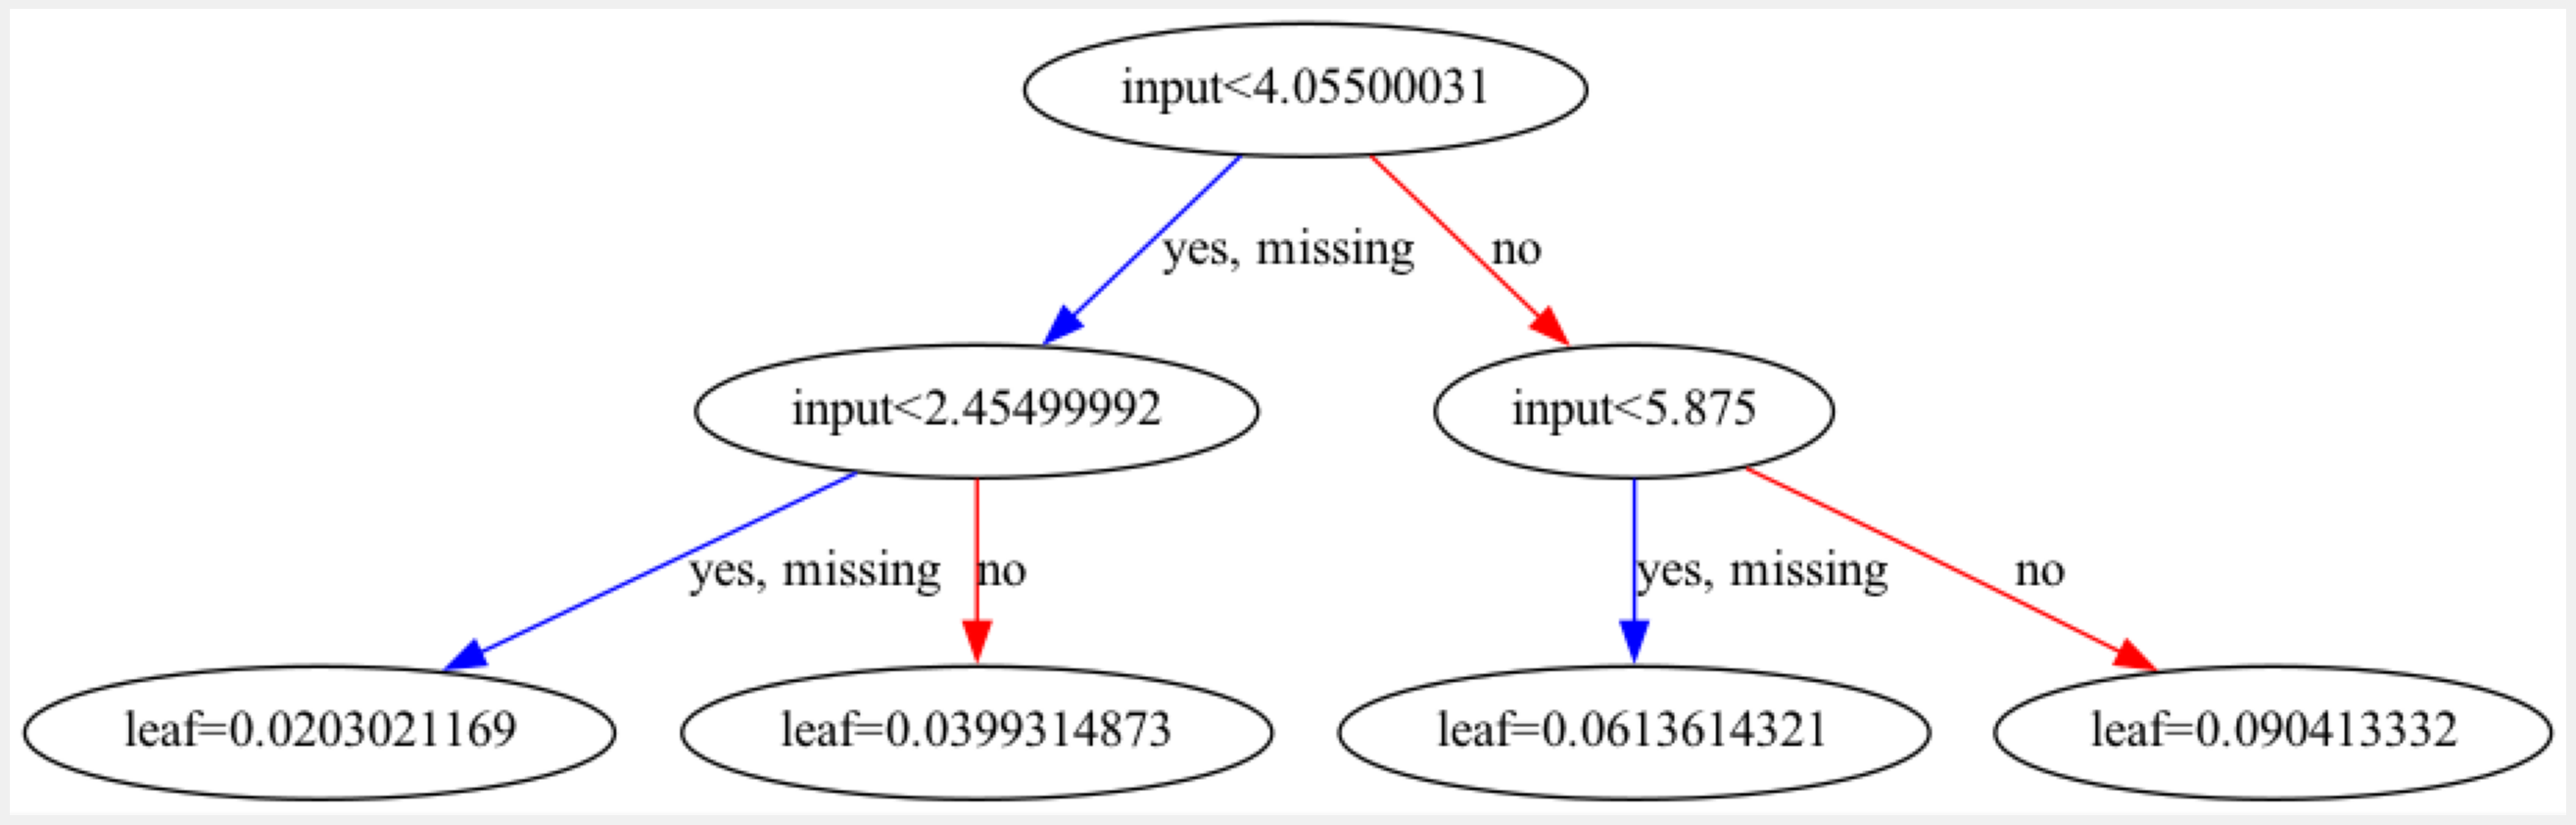

In [24]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(estimator, num_trees=16, ax=ax)
plt.show()

---
# Model Testing

In [25]:
predictions = estimator.predict(X_test)

In [26]:
scores = np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))
scores

0.2819254

In [27]:
result = pd.DataFrame({
    'prediction': predictions, 
    'truth': y_test
})
result['deviation %'] = np.abs((1.0 - result['prediction'] / result['truth']) * 100.0)
result

,prediction,truth,deviation %
221,3.567757,3.55,0.500214
439,3.689211,3.25,13.514185
33,2.554617,1.95,31.006014
442,3.300415,3.14,5.108750
568,2.250277,2.45,8.151960
...,...,...,...
611,2.329185,2.45,4.931206
294,3.253545,2.83,14.966261
4,3.293158,3.10,6.230903
668,2.449368,2.60,5.793553


## Percentage of deviation (mean)

In [28]:
result['deviation %'].mean()

7.5738616

---
# Model Saving

In [29]:
estimator.save_model("xgb_model_sklearn.txt")

/Users/oonisim/venv/ml/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: eval_metric is not saved in Scikit-Learn meta.
  warnings.warn(


## Test saved model

In [30]:
model_to_verify = xgb.XGBRegressor()
model_to_verify.load_model("xgb_model_sklearn.txt")

In [31]:
predictions = estimator.predict(X_test)

In [32]:
scores = np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))
scores

0.2819254